# Experiment 1.3 XGBoost with class balancing

Try to improve on the xgboost model score by treating the class imbalance in the training data. Can do this by resampling using various techniques:

1. Adjust the weight of the positive class in xgboost (scale_pos_weight)
2. Upsample or downsample the adta
3. Synthetic Minority Oversampling Technique (SMOTE)

Experiments will be tried in this order (from least to most destructive)

Simple examples to follow

https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

https://elitedatascience.com/imbalanced-classes

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

The previous kaggle AUC to beat is 0.70615. 
The best validation AUC so far is 0.70257.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [2]:
# import load_data function from helper file 
%load_ext autoreload
%autoreload 2

# fix system path
import sys
sys.path.append("/home/jovyan/work")

In [3]:
from src.features.helper_functions import load_sets

X_train, y_train, X_val, y_val, X_test = load_sets()

## Scaling positive class weight

Check the class counts again

In [4]:
# check distribution of the target
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [1074 5326]]


The documentation for xgboost suggests that the number to use in the scale_pos_weight argument is the ratio of negative (0) to positive (1).

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
https://xgboost.readthedocs.io/en/latest/parameter.html
https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets

In this case, the positive class outweights the negative, so the imbalance is flipped, therefore our ratio will be <1.

In [5]:
1074/5326

0.2016522718738265

Ratio is 20% 0 to 1, so for the weights in xgboost use 
scale_pos_weight=0.2.

## Train using class weights
Use stratified kfold for cross validation - need to use this to assess the effectiveness of applying weights

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# create kfold object
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [7]:
# instatiate model
model = XGBClassifier(scale_pos_weight=0.2)

In [8]:
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=kfold, n_jobs=-1)

In [9]:
# summarise performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.64356


In [10]:
scores

array([0.67803475, 0.6398976 , 0.63505813, 0.60856376, 0.62532658,
       0.60817801, 0.59910192, 0.69287803, 0.64531119, 0.70321637])

Not the best mean AUC, but the highest fold achieved 0.703. Try a small grid search experiment using a range of weights to see if a slightly different value is better.

In [14]:
from sklearn.model_selection import GridSearchCV

# define grid
weights = [0.2, 0.1, 0.3, 0.4]
param_grid = dict(scale_pos_weight=weights)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring='roc_auc')

In [15]:
# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:35:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.651327 using {'scale_pos_weight': 0.1}
0.643557 (0.034719) with: {'scale_pos_weight': 0.2}
0.651327 (0.023777) with: {'scale_pos_weight': 0.1}
0.645143 (0.026614) with: {'scale_pos_weight': 0.3}
0.636430 (0.022929) with: {'scale_pos_weight': 0.4}


The AUC was best with weight at 0.1, which was higher than the mean AUC from above. Try smaller increments between 0.1 and 0.2.

In [17]:
# define grid
weights = [0.125, 0.15, 0.175]
param_grid = dict(scale_pos_weight=weights)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.643178 using {'scale_pos_weight': 0.15}
0.639835 (0.033028) with: {'scale_pos_weight': 0.125}
0.643178 (0.028156) with: {'scale_pos_weight': 0.15}
0.639867 (0.023654) with: {'scale_pos_weight': 0.175}


Smaller increments did not make a difference, use weight = 0.1. 

Can the AUC score be improved using the previous tuned model with this added weight parameter?

In [11]:
# load previous model
# from joblib import load
# model_best_params = load('../models/rex_xgb_gridsearch.joblib')

## Use weight scale with previous best model parameters

In [18]:
# instantiate model with weights and best params
model = XGBClassifier(max_depth = 2, n_estimators = 140, learning_rate = 0.05, scale_pos_weight=0.1)

In [19]:
# fit model
model_weight_bp = model.fit(X_train, y_train)

[10:50:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
from src.features.helper_functions import save_model

In [21]:
save_model(model_weight_bp, 'rez_xgb_bestparam_weight')

Model saved succesfully


## Predict on train & val set

In [22]:
# predict class
y_train_preds = model_weight_bp.predict(X_train)
y_val_preds = model_weight_bp.predict(X_val)

In [23]:
# predict proabilities
y_train_preds_prob = model_weight_bp.predict_proba(X_train)
y_val_preds_prob = model_weight_bp.predict_proba(X_val)

In [ ]:
from sklearn.metrics import roc_auc_score ,recall_score, precision_score, accuracy_score, classification_report, plot_confusion_matrix
    
accuracy = accuracy_score(y_train, y_train_preds_prob)
precision=precision_score(y_train, y_train_preds_prob)
recall=recall_score(y_train, y_train_preds_prob)
roc=roc_auc_score(y_train, y_train_preds_prob)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%% " % (precision *100))
print("Recall: %.2f%% " % (recall * 100))
print("AUC: %.3f%% " % (roc *100))

class_report = classification_report(y_train, y_train_preds_prob)
print(class_report)
    
plot_confusion_matrix(model_weight_bp, X_train, y_train, cmap=plt.cm.Blues)  
plt.show() 

In [35]:
from sklearn.metrics import classification_report

class_report = classification_report(y_val, y_val_preds)
print(class_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       257
           1       0.84      1.00      0.91      1343

    accuracy                           0.84      1600
   macro avg       0.42      0.50      0.46      1600
weighted avg       0.70      0.84      0.77      1600



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train, y_train_preds_prob[:,1]))
print(roc_auc_score(y_val, y_val_preds_prob[:,1]))

0.7343423848853627
0.7034413923181447


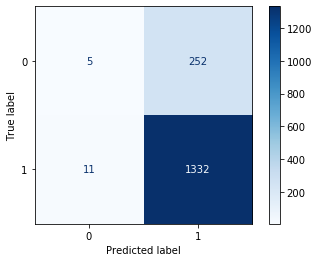

In [38]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_best_params, X_val, y_val, cmap=plt.cm.Blues)  
plt.show() 